Importing Packages 

In [39]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns  
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold

import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

Opening pickle from cleaning notebook

In [40]:
with open('//Users/adelweiss/Documents/Project/Project 2/data/df.pickle','rb') as read_file:
    df = pickle.load(read_file)

Cleaning combined dataset 

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 51 to 208
Data columns (total 17 columns):
Dengue Cases                          261 non-null float64
eweek                                 261 non-null object
Daily Rainfall Total (mm)             251 non-null float64
Mean Temperature (°C)                 251 non-null float64
Maximum Temperature (°C)              251 non-null float64
Minimum Temperature (°C)              251 non-null float64
fever: (Singapore)                    260 non-null float64
Nausea: (Singapore)                   260 non-null float64
headache: (Singapore)                 260 non-null float64
ache + pain: (Singapore)              260 non-null float64
dengue fever: (Singapore)             260 non-null float64
eye pain: (Singapore)                 260 non-null float64
dengue: (Singapore)                   260 non-null float64
dengue fever symptoms: (Singapore)    260 non-null float64
rashes: (Singapore)                   260 non-null float64
Vomiting: 

In [42]:
### dropping NAs, 
df.dropna(inplace = True)

### dropping these search terms because dengue would have covered them already 
df.drop(columns = ['dengue fever symptoms: (Singapore)', 'dengue fever: (Singapore)'], inplace = True)

In [43]:
### I think i want to create temperature range based on the mean and max temperature... 
### I think lower temperature fluctuations should be better for breeding 
df ['Temperature Range'] = df['Maximum Temperature (°C)'] - df['Minimum Temperature (°C)']

In [44]:
#sns.pairplot(df)

In [45]:
### log transform dengue cases to correct for postive skew 
### I tried the other transformation as well, but log seems to have the best results 

df['log Dengue Cases Week+1'] = np.log(df['Dengue Cases Week+1'])
#df['sq root Dengue Cases Week+1'] = np.sqrt(df['Dengue Cases Week+1'])
#df['cbrt Dengue Cases Week+1'] = np.cbrt(df['Dengue Cases Week+1'])

In [46]:
### making sure these variables are not thrown into the model 
df = df.drop(columns = ['Dengue Cases Week+1','eweek', 'Dengue Cases'])

In [47]:
### i also need easier column names 
df.columns = ['rainfall', 'mean_temp', 'max_temp', 'min_temp', 'fever', 'nausea', 'headache',
             'ache_pain', 'eye_pain', 'dengue', 'rashes', 'vomitting', 'temp_range', 'log_dengue_cases']

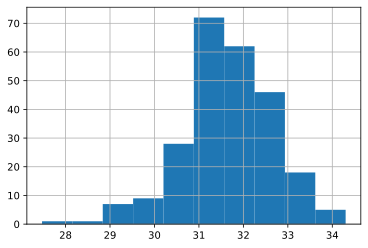

In [55]:
df.max_temp.hist()

Cross validation of regressions model 

In [11]:
###split into train and test 
X, y = df.drop(['log_dengue_cases'],axis=1), df['log_dengue_cases']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, y_train = np.array(X_train), np.array(y_train) 

In [13]:
### then compare which is the best models...
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_poly_r2s, cv_lm_reg_r2s, cv_lm_lasso_r2s = [], [], [], []#collect the validation results for both models

for train_ind, val_ind in kf.split(X_train,y_train):
    X_trainfold, y_trainfold = X_train[train_ind], y_train[train_ind]
    X_val, y_val = X_train[val_ind], y_train[val_ind] 
    
    #Scale variables 
    scaler = StandardScaler()
    X_trainfold_scaled = scaler.fit_transform(X_trainfold)
    X_val_scaled = scaler.transform(X_val)
    
    #simple linear regression  
    lm = LinearRegression()
    lm.fit(X_trainfold_scaled, y_trainfold)
    cv_lm_r2s.append(lm.score(X_val_scaled, y_val))
    
    #polynomial with feature scaling
    lm_poly = LinearRegression()
    poly = PolynomialFeatures(degree=2) 
    X_train_poly = poly.fit_transform(X_trainfold_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    lm_poly.fit(X_train_poly, y_trainfold)
    cv_lm_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
    
    #ridge regression with feature scaling 
    lm_reg = Ridge()
    #lm_reg = Ridge(alpha=14)
    lm_reg.fit(X_trainfold_scaled, y_trainfold)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    #lasso regression with feature scaling 
    lm_lasso = Lasso()
    #lm_lasso = Lasso(alpha = 0.01)
    lm_lasso.fit(X_trainfold_scaled, y_trainfold)
    cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))
    
print('Simple regression scores: ', cv_lm_r2s)
print('Polynomial scores: ', cv_lm_poly_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_r2s, '\n')
print('Lasso scores: ', cv_lm_lasso_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Polynomial mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')

Simple regression scores:  [0.6313376791780044, 0.7191007874767281, 0.6165640991198559, 0.7104278472993533, 0.7249533815052178]
Polynomial scores:  [0.23423126493100555, 0.5508421140492604, 0.05516646306818085, 0.40769334977163907, 0.5287565202074851] 

Ridge scores:  [0.6315597966013227, 0.7180683147167511, 0.6195861997393652, 0.7129514228947417, 0.7246492778444309] 

Lasso scores:  [-0.0031127017367751364, -0.0007056619328711378, -0.0067744660521424915, -0.011998311662609895, -3.884706093204571e-05] 

Simple mean cv r^2: 0.680 +- 0.047
Polynomial mean cv r^2: 0.355 +- 0.188
Ridge mean cv r^2: 0.681 +- 0.046
Lasso mean cv r^2: -0.005 +- 0.004


Looks like simple linear is the way to go. Let's try to do some feature selection using Lasso

In [14]:
### looks like non-polynomial is the way to go.... 
### let's try to reduce the model complexity 
### thru feature selection before we optimise alpha for ridge

#need to redo this cuz CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
### Scaling the variables 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

### Applying lasso model on the train dataset 
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_scaled, y_train)
list(zip(X_train, lasso_model.coef_))

[('rainfall', 0.018486502183935594),
 ('mean_temp', 0.06868522482234792),
 ('max_temp', 0.026536406294192606),
 ('min_temp', 0.0),
 ('fever', -0.0),
 ('nausea', -0.009261962178631948),
 ('headache', -0.1746509507064813),
 ('ache_pain', -0.21498344015848214),
 ('eye_pain', 0.005246565794440529),
 ('dengue', 0.5340757673776464),
 ('rashes', 0.06608732040162081),
 ('vomitting', -0.009559889817956992),
 ('temp_range', 0.027529964438859626)]

In [15]:
###dropping columns that hit zero or v close to zero for optimal lasso 
df = df.drop(columns = ['min_temp', 'fever', 'vomitting', 'eye_pain', 'nausea'])

In [16]:
X, y = df.drop(['log_dengue_cases'],axis=1), df['log_dengue_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, y_train = np.array(X_train), np.array(y_train) 

In [17]:
### then compare which is the best models...
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s  = [], []#collect the validation results for both models

for train_ind, val_ind in kf.split(X_train,y_train):
    X_trainfold, y_trainfold = X_train[train_ind], y_train[train_ind]
    X_val, y_val = X_train[val_ind], y_train[val_ind] 
    
    #Scale variables 
    scaler = StandardScaler()
    X_trainfold_scaled = scaler.fit_transform(X_trainfold)
    X_val_scaled = scaler.transform(X_val)
    
    #simple linear regression using feature scaling 
    lm = LinearRegression()
    lm.fit(X_trainfold_scaled, y_trainfold)
    cv_lm_r2s.append(lm.score(X_val_scaled, y_val))
        
    #ridge regression with feature scaling 
    lm_reg = Ridge()
    lm_reg.fit(X_trainfold_scaled, y_trainfold)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')


Simple regression scores:  [0.6316754541360685, 0.743256589861764, 0.6498550179999606, 0.7184251575479973, 0.7276343377840486]
Ridge scores:  [0.6315928590436379, 0.7437095083303944, 0.652024759155142, 0.7206629930036234, 0.7266500913111185] 

Simple mean cv r^2: 0.694 +- 0.045
Ridge mean cv r^2: 0.695 +- 0.044


In [18]:
### doing this again cuz RidgeCV doesn't handle arrays 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)
### Scaling the variables 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

### Applying lasso model on the train dataset 
alphavec = 10**np.linspace(-2,2,200)
reg_model = RidgeCV(alphas = alphavec, cv=5)
reg_model.fit(X_train_scaled, y_train)
reg_model.alpha_
#list(zip(X_train, lasso_model.coef_))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


10.843659686896109

In [19]:
### not much difference in r2, so let's try both 
reg_model = Ridge(alpha = 10.8) 
reg_model.fit(X_train_scaled, y_train)
reg_model.score(X_test_scaled, y_test)

0.7286591619349561

In [20]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
lm.score(X_test_scaled, y_test)

### let's just stick to the simple model.. 

0.7329044518696068

Test assumptions of model 

In [21]:
df_for_stats_model = pd.DataFrame(X_train_scaled)
df_for_stats_model.columns = list(X_train.columns)

In [22]:
y_train_df = pd.DataFrame(y_train).reset_index().drop(columns = ['index'])
df_for_stats_model['log_dengue_cases'] = y_train_df

In [23]:
df_for_stats_model.corr()

,rainfall,mean_temp,max_temp,headache,ache_pain,dengue,rashes,temp_range,log_dengue_cases
rainfall,1.000000,-0.354396,-0.331282,0.034075,0.007182,-0.042282,-0.034545,0.113353,-0.037025
mean_temp,-0.354396,1.000000,0.769936,0.083602,0.097519,0.170027,-0.065418,-0.063814,0.169914
max_temp,-0.331282,0.769936,1.000000,0.074383,0.119010,0.009234,-0.136666,0.524623,0.069570
headache,0.034075,0.083602,0.074383,1.000000,0.383826,-0.222818,0.045891,0.028340,-0.440802
ache_pain,0.007182,0.097519,0.119010,0.383826,1.000000,-0.203904,-0.017107,0.049539,-0.461105
dengue,-0.042282,0.170027,0.009234,-0.222818,-0.203904,1.000000,0.205042,-0.155968,0.757690
rashes,-0.034545,-0.065418,-0.136666,0.045891,-0.017107,0.205042,1.000000,-0.158169,0.197196
temp_range,0.113353,-0.063814,0.524623,0.028340,0.049539,-0.155968,-0.158169,1.000000,-0.064897
log_dengue_cases,-0.037025,0.169914,0.069570,-0.440802,-0.461105,0.757690,0.197196,-0.064897,1.000000


In [24]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('log_dengue_cases ~ rainfall + mean_temp + max_temp + headache + ache_pain + dengue + rashes + temp_range' , 
                       data=df_for_stats_model, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_dengue_cases   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     63.52
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           1.21e-49
Time:                        17:09:30   Log-Likelihood:                -123.18
No. Observations:                 199   AIC:                             264.4
Df Residuals:                     190   BIC:                             294.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8549      0.033    148.927      0.000       4.791       4.919
rainfall       0.0331      0.039      0.850      0.396      -0.044       0.110
mean_temp      0.1294      0.108      1.198      0.232      -0.084       0.342
max_temp      -0.0192      0.132     -0.145      0.885      -0.280       0.241
headache      -0.1887      0.036     -5.208      0.000      -0.260      -0.117
ache_pain     -0.2278      0.036     -6.350      0.000      -0.299      -0.157
dengue         0.5380      0.036     14.891      0.000       0.467       0.609
rashes         0.0827      0.034      2.425      0.016       0.015       0.150
temp_range     0.0723      0.084      0.861      0.391      -0.093       0.238
==============================================================================
Omnibus:                        0.504   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.635
Skew:                           0.098   Prob(JB):                        0.728
Kurtosis:                       2.805   Cond. No.                         8.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
### remove max_temp, rainfall 
### when we removed temp_range the r2 started to fall 

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('log_dengue_cases ~ mean_temp + headache + ache_pain + dengue + rashes + temp_range' , 
                       data=df_for_stats_model, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_dengue_cases   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     84.94
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           2.36e-51
Time:                        17:11:11   Log-Likelihood:                -123.72
No. Observations:                 199   AIC:                             261.4
Df Residuals:                     192   BIC:                             284.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8549      0.033    149.302      0.000       4.791       4.919
mean_temp      0.1014      0.034      3.007      0.003       0.035       0.168
headache      -0.1859      0.036     -5.164      0.000      -0.257      -0.115
ache_pain     -0.2272      0.036     -6.361      0.000      -0.298      -0.157
dengue         0.5412      0.036     15.206      0.000       0.471       0.611
rashes         0.0803      0.034      2.367      0.019       0.013       0.147
temp_range     0.0642      0.033      1.930      0.055      -0.001       0.130
==============================================================================
Omnibus:                        0.734   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.693   Jarque-Bera (JB):                0.860
Skew:                           0.119   Prob(JB):                        0.650
Kurtosis:                       2.784   Cond. No.                         1.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
new_df = df.drop(columns = ['max_temp', 'rainfall'])
X, y = df.drop(['log_dengue_cases'],axis=1), df['log_dengue_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)


In [35]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
lm.score(X_test_scaled, y_test)
r_test = lm.score(X_test_scaled, y_test)

In [38]:
r_test

0.7329044518696068

In [36]:
r2 = 1-(1-r_test)*(X_train_scaled.shape[0]-1)/(X_train_scaled.shape[0]-X_train_scaled.shape[1]-1)

In [37]:
r2

0.7216583235272744